In [97]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(2115, 22, 1000)
(2115, 22, 1000)
(2115, 1000)


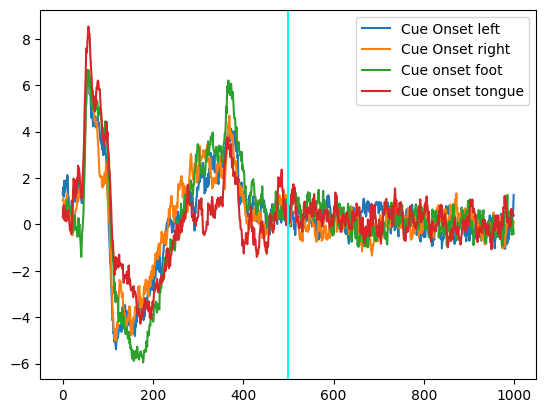

In [98]:
## Loading and visualizing the data

## Loading the dataset
X_test = np.load("../ECEC147project-data/X_test.npy")
y_test = np.load("../ECEC147project-data//y_test.npy")
person_train_valid = np.load("../ECEC147project-data//person_train_valid.npy")
X_train_valid = np.load("../ECEC147project-data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("../ECEC147project-data/y_train_valid.npy")
person_test = np.load("../ECEC147project-data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data
print(X_train_valid.shape)
ch_data = X_train_valid[:,8,:]
print(ch_data.shape)
class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [99]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [100]:

# Preprocessing test dataset
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# First split then do preprocessing separately
# Creating the training and validation sets using the generated indices
(x_train_split, x_valid_split) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_split, y_valid_split) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Preprocessing the dataset after split to prevent leakage (augmentation and smoothing)
x_train,y_train = train_data_prep(x_train_split,y_train_split,2,2,True)
x_valid,y_valid = train_data_prep(x_valid_split,y_valid_split,2,2,True)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after averaging+noise and concatenating: (500, 22, 400)
Shape of X after subsampling and concatenating: (1000, 22, 400)
Shape of Y: (1000,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after

(1000, 400, 1, 22)
(1000, 400, 22)
(1000, 400)


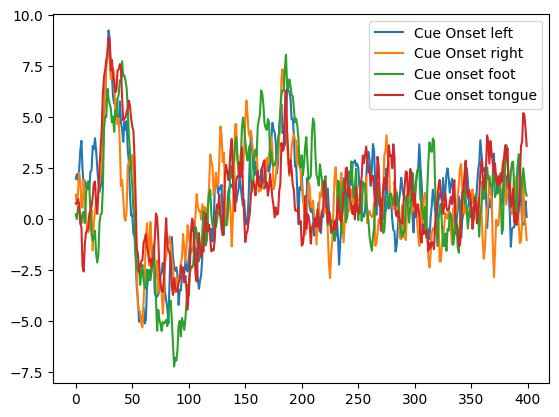

In [101]:
print(x_valid.shape)

ch_data1 = x_valid[:,:,0]
print(ch_data1.shape)
ch_data1 = ch_data1[:, :, 8]
print(ch_data1.shape)
class_0_ind = np.where(y_valid[:, 0] == 1)
ch_data_class_0 = ch_data1[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)

class_1_ind = np.where(y_valid[:, 1] == 1)
ch_data_class_1 = ch_data1[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_valid[:, 2] == 1)
ch_data_class_2 = ch_data1[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_valid[:, 3] == 1)
ch_data_class_3 = ch_data1[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(400),avg_ch_data_class_0)
plt.plot(np.arange(400),avg_ch_data_class_1)
plt.plot(np.arange(400),avg_ch_data_class_2)
plt.plot(np.arange(400),avg_ch_data_class_3)

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [102]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 134, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 134, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 134, 1, 25)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 1, 50)        

In [103]:
# Model parameters
learning_rate = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
epochs = [100, 125, 150, 175, 200]

In [104]:
learning_rate_accuracy = []
epochs_accuracy = []
for i in range (len(learning_rate)):
    hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate[i])
    # Compiling the model
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid, y_valid), verbose=True)
    # Testing accuracy 
    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
    learning_rate_accuracy.append(hybrid_cnn_lstm_score[1])

for i in range (len(epochs)):
    hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(1e-3)
    # Compiling the model
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=epochs[i],
                validation_data=(x_valid, y_valid), verbose=True)
    # Testing accuracy 
    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
    epochs_accuracy.append(hybrid_cnn_lstm_score[1])


Epoch 1/150
117/117 [==============================] - 10s 64ms/step - loss: 1.3629 - accuracy: 0.3188 - val_loss: 1.3044 - val_accuracy: 0.3800
Epoch 2/150
117/117 [==============================] - 8s 65ms/step - loss: 1.2907 - accuracy: 0.3877 - val_loss: 1.2428 - val_accuracy: 0.4560
Epoch 3/150
117/117 [==============================] - 7s 63ms/step - loss: 1.2457 - accuracy: 0.4315 - val_loss: 1.2266 - val_accuracy: 0.4420
Epoch 4/150
117/117 [==============================] - 7s 63ms/step - loss: 1.2073 - accuracy: 0.4521 - val_loss: 1.2197 - val_accuracy: 0.4420
Epoch 5/150
117/117 [==============================] - 7s 64ms/step - loss: 1.1807 - accuracy: 0.4681 - val_loss: 1.2264 - val_accuracy: 0.4370
Epoch 6/150
117/117 [==============================] - 7s 61ms/step - loss: 1.1580 - accuracy: 0.4757 - val_loss: 1.2022 - val_accuracy: 0.4460
Epoch 7/150
117/117 [==============================] - 8s 64ms/step - loss: 1.1458 - accuracy: 0.4748 - val_loss: 1.1819 - val_accuracy

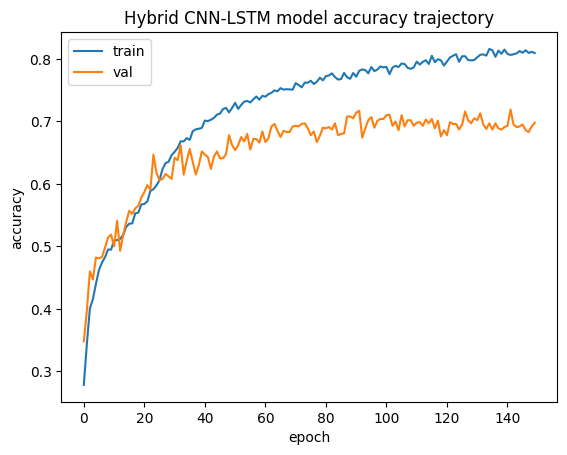

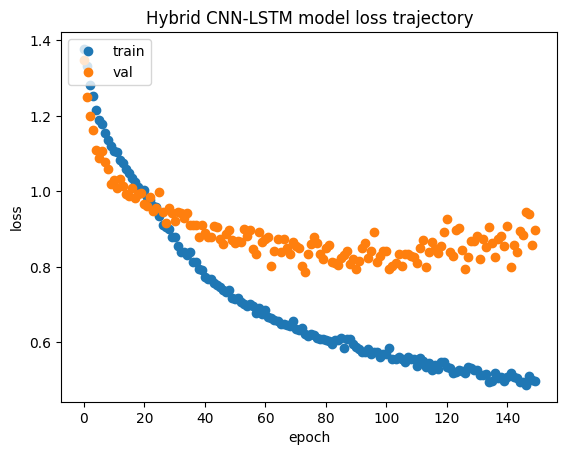

In [ ]:
# # Plotting accuracy trajectory
# plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
# plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
# plt.title('Hybrid CNN-LSTM model accuracy trajectory')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# # Plotting loss trajectory
# plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
# plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
# plt.title('Hybrid CNN-LSTM model loss trajectory')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# history of best models

max_index1 = np.argmax(learning_rate_accuracy)
max_index2 = np.argmax(epoch_accuracy)

In [ ]:
## Testing the hybrid CNN-LSTM model
# hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
# print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

[[[[ 10.05859375   4.8828125    9.91210938 ...   9.81445312
      9.61914062  12.59765625]]

  [[  5.2734375    3.95507812   6.10351562 ...   2.83203125
      2.5390625    0.34179688]]

  [[  1.953125     4.4921875    4.34570312 ...  -1.7578125
     -1.46484375  -4.24804688]]

  ...

  [[  6.0546875    0.390625     4.1015625  ...   2.78320312
      1.70898438   0.63476562]]

  [[-13.8671875  -14.453125   -15.77148438 ...  -4.24804688
     -4.8828125   -2.97851562]]

  [[-15.234375   -13.8671875  -17.52929688 ...  -3.3203125
     -4.19921875  -1.80664062]]]


 [[[-27.34375    -21.19140625 -26.22070312 ... -15.8203125
    -13.0859375  -10.00976562]]

  [[-22.11914062 -19.38476562 -25.53710938 ... -12.06054688
     -9.42382812  -5.90820312]]

  [[-19.62890625 -16.40625    -20.45898438 ...  -9.9609375
    -10.98632812  -6.93359375]]

  ...

  [[ -2.83203125  -3.95507812  -4.63867188 ... -10.20507812
     -9.03320312 -12.25585938]]

  [[ -8.0078125   -2.58789062  -7.2265625  ... -11.2792968

In [ ]:
# Plotting testing accuracy vs. learning rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rate, learning_rate_accuracy, marker='o', linestyle='-', color='b')
plt.xscale('log')  
plt.title('Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plotting testing accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, epochs_accuracy, marker='o', linestyle='-', color='r')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
